# Introduction

In this notebook, we build and train two deep neural network models, namely CNN and Bi-LSTM, to classify drug categories from a set of online drug reviews using Tensorflow/Keras and UCI Drug Review dataset.

At the end of this experiement, our models are able to classify 14 different drug categories from drug reviews with an overall accuracy of approximately 89% 

In [1]:
import pickle
import zipfile
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [2]:
EMBEDDING_DIM = 50 # how big is each word vector
MAX_NB_WORDS = 50000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 250 # max number of words in a review to use

# Data Preprocessing

## Data Cleaning

In [3]:
# data cleaning
def review_clean(review): 
    # changing to lower case
    lower = review.str.lower()
    
    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039;", "", regex = True)
    
    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ', regex = True)
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ', regex = True)
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','', regex = True)
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ', regex = True)
    
    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ', regex = True)
    
    return dataframe

In [4]:
def clean_dataframe(data, target_conditions):
    data = data[['condition', 'review']]

    # remove NULL Values from data
    data = data[pd.notnull(data['review'])]

    # filter data with selected conditions
    data = data[data['condition'].isin(target_conditions)]
    
    data['review'] = review_clean(data['review'])
    
    return data

In [6]:
train = pd.read_csv('drug_train.csv')
test = pd.read_csv('drug_test.csv')

data = pd.concat([train, test])[['review','condition']]
data.head()

,review,condition
0,"""It has no side effect, I take it in combinati...",Left Ventricular Dysfunction
1,"""My son is halfway through his fourth week of ...",ADHD
2,"""I used to take another oral contraceptive, wh...",Birth Control
3,"""This is my first time using any form of birth...",Birth Control
4,"""Suboxone has completely turned my life around...",Opiate Dependence


In [7]:
# review counts for each condition
review_counts = data[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
# select conditions that have at least 3000 reviews
target_conditions = review_counts[review_counts['review'] > 3000]['condition'].tolist()
print(target_conditions)

['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Acne', 'Bipolar Disorde', 'Insomnia', 'Weight Loss', 'Obesity', 'ADHD', 'Diabetes, Type 2', 'Emergency Contraception', 'High Blood Pressure', 'Vaginal Yeast Infection']


In [8]:
train = clean_dataframe(train, target_conditions)
test = clean_dataframe(test, target_conditions)

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83563 entries, 1 to 161291
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   condition  83563 non-null  object
 1   review     83563 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28001 entries, 0 to 53764
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   condition  28001 non-null  object
 1   review     28001 non-null  object
dtypes: object(2)
memory usage: 656.3+ KB
None


## Data Tokenization

In [9]:
X_train = train['review']
y_train = train['condition']
X_test = test['review']
y_test = test['condition']

# train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# encode drug categories to numbers
le = LabelEncoder()
y_train = le.fit_transform(y_train.values)
y_val = le.fit_transform(y_val.values)
y_test = le.transform(y_test.values)

# encode drug category numbers to binary class vectors 
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(75206,)
(8357,)
(28001,)


In [10]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['review'])
word_index = tokenizer.word_index
if (len(word_index) < MAX_NB_WORDS):
    raise Exception('Found %s unique tokens. MUST greater than MAX_NB_WORDS = %s. Set MAX_NB_WORDS to a lower number' % (len(word_index), MAX_NB_WORDS))
print('Found %s unique tokens' % len(word_index))

Found 59960 unique tokens


In [11]:
x_train_tokens = tokenizer.texts_to_sequences(X_train)
x_val_tokens = tokenizer.texts_to_sequences(X_val)
x_test_tokens = tokenizer.texts_to_sequences(X_test)

x_train = pad_sequences(x_train_tokens, maxlen = MAX_SEQUENCE_LENGTH)
x_val = pad_sequences(x_val_tokens, maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(x_test_tokens, maxlen = MAX_SEQUENCE_LENGTH)

# Prediction Models

## Word Embedding

In [12]:
with zipfile.ZipFile("glove.6B.50d.txt.zip", 'r') as zip_ref:
    zip_ref.extractall()

EMBEDDING_FILE = 'glove.6B.50d.txt'

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

word_index = tokenizer.word_index
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


## CNN

In [13]:
#For CNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Embedding, Input, GlobalMaxPool1D

# Create a CNN model with a Word Embedding layer using glove.6B data
cnn_inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
cnn_out = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, weights=[embedding_matrix])(cnn_inp)
cnn_out = Conv1D(filters=128, kernel_size=5, activation='relu')(cnn_out)
cnn_out = GlobalMaxPool1D()(cnn_out)
cnn_out = Dense(50, activation='relu')(cnn_out)
cnn_out = Dropout(0.1)(cnn_out)
cnn_out = Dense(len(target_conditions), activation='softmax')(cnn_out)
cnn_model = Model(inputs=cnn_inp, outputs=cnn_out)
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(cnn_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 50)           2500000   
                                                                 
 conv1d (Conv1D)             (None, 246, 128)          32128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                6450      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                             

In [14]:
cnn_model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))
print(cnn_model.evaluate(x_test, y_test))

Epoch 1/5
588/588 [==============================] - 29s 49ms/step - loss: 1.1184 - accuracy: 0.6448 - val_loss: 0.5571 - val_accuracy: 0.8166
Epoch 2/5
588/588 [==============================] - 29s 49ms/step - loss: 0.5190 - accuracy: 0.8262 - val_loss: 0.4307 - val_accuracy: 0.8526
Epoch 3/5
588/588 [==============================] - 29s 49ms/step - loss: 0.3943 - accuracy: 0.8646 - val_loss: 0.3803 - val_accuracy: 0.8703
Epoch 4/5
588/588 [==============================] - 29s 49ms/step - loss: 0.3215 - accuracy: 0.8899 - val_loss: 0.3461 - val_accuracy: 0.8799
Epoch 5/5
876/876 [==============================] - 3s 3ms/step - loss: 0.3428 - accuracy: 0.8872
[0.34277287125587463, 0.8871825933456421]


In [15]:
cnn_preds= cnn_model.predict(x=x_test, batch_size=64, verbose=1)

cnn_true = [le.classes_[x] for x in y_test.argmax(axis=1)]
cnn_pred = [le.classes_[x] for x in cnn_preds.argmax(axis=1)]

438/438 [==============================] - 2s 5ms/step


In [16]:
print(accuracy_score(cnn_true, cnn_pred))
print(classification_report(cnn_true, cnn_pred))

0.8871826006214064
                         precision    recall  f1-score   support

                   ADHD       0.90      0.88      0.89      1126
                   Acne       0.94      0.92      0.93      1847
                Anxiety       0.81      0.72      0.77      1908
        Bipolar Disorde       0.87      0.75      0.80      1380
          Birth Control       0.97      0.98      0.98      9648
             Depression       0.75      0.88      0.81      3095
       Diabetes, Type 2       0.93      0.86      0.89       808
Emergency Contraception       0.98      0.95      0.96       827
    High Blood Pressure       0.91      0.85      0.88       783
               Insomnia       0.86      0.82      0.84      1231
                Obesity       0.71      0.61      0.66      1189
                   Pain       0.88      0.94      0.91      2100
Vaginal Yeast Infection       0.96      0.94      0.95       811
            Weight Loss       0.69      0.73      0.71      1248

    

Text(69.0, 0.5, 'Actuals')

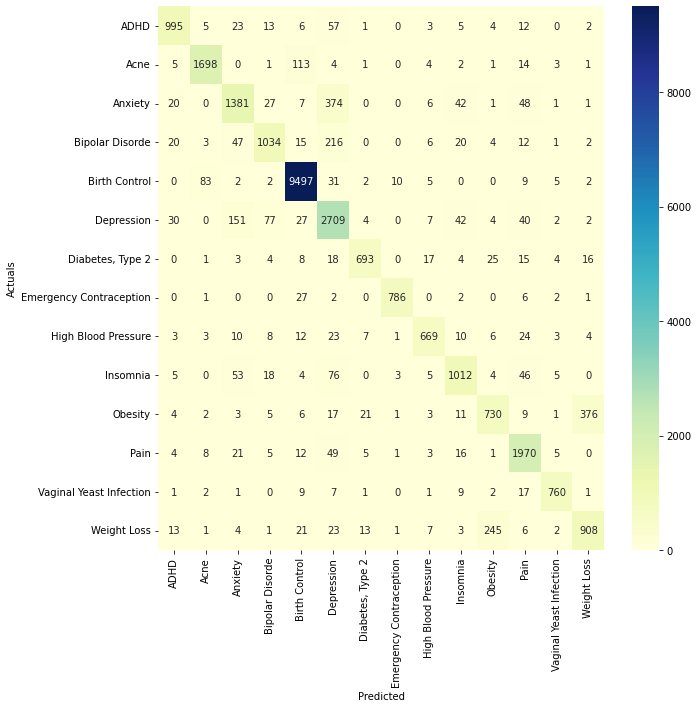

In [17]:
cnn_cm = confusion_matrix(cnn_true, cnn_pred)
plt.subplots(figsize=(10,10))
sns.heatmap(cnn_cm, annot=True, xticklabels=le.classes_, yticklabels=le.classes_, fmt='g', cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actuals")

## LSTM

In [18]:
#For LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, Embedding, Input, GlobalMaxPool1D, LSTM

# Create the custom model with a Word Embedding layer using glove.6B data
lstm_inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
lstm_out = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, weights=[embedding_matrix])(lstm_inp)
lstm_out = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(lstm_out)
lstm_out = GlobalMaxPool1D()(lstm_out)
lstm_out = Dense(50, activation='relu')(lstm_out)
lstm_out = Dropout(0.1)(lstm_out)
lstm_out = Dense(len(target_conditions), activation='softmax')(lstm_out)
lstm_model = Model(inputs=lstm_inp, outputs=lstm_out)
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 250, 50)           2500000   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 100)         40400     
 l)                                                              
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0   

In [19]:
lstm_model.fit(x_train, y_train, epochs=7, batch_size=128, validation_data=(x_val, y_val))
print(lstm_model.evaluate(x_test, y_test))

Epoch 1/7
588/588 [==============================] - 386s 652ms/step - loss: 1.3191 - accuracy: 0.5748 - val_loss: 0.6961 - val_accuracy: 0.7669
Epoch 2/7
588/588 [==============================] - 425s 722ms/step - loss: 0.5770 - accuracy: 0.8026 - val_loss: 0.4508 - val_accuracy: 0.8401
Epoch 3/7
588/588 [==============================] - 448s 762ms/step - loss: 0.4389 - accuracy: 0.8466 - val_loss: 0.3928 - val_accuracy: 0.8582
Epoch 4/7
588/588 [==============================] - 468s 796ms/step - loss: 0.3768 - accuracy: 0.8679 - val_loss: 0.3705 - val_accuracy: 0.8702
Epoch 5/7
588/588 [==============================] - 471s 801ms/step - loss: 0.3336 - accuracy: 0.8820 - val_loss: 0.3467 - val_accuracy: 0.8779
Epoch 6/7
588/588 [==============================] - 472s 803ms/step - loss: 0.3005 - accuracy: 0.8937 - val_loss: 0.3336 - val_accuracy: 0.8837
Epoch 7/7
876/876 [==============================] - 23s 27ms/step - loss: 0.3282 - accuracy: 0.8871
[0.3281707465648651, 0.887146

In [20]:
lstm_preds= lstm_model.predict(x=x_test, batch_size=64, verbose=1)

lstm_true = [le.classes_[x] for x in y_test.argmax(axis=1)]
lstm_pred = [le.classes_[x] for x in lstm_preds.argmax(axis=1)]

438/438 [==============================] - 50s 113ms/step


In [21]:
print(accuracy_score(lstm_true, lstm_pred))
print(classification_report(lstm_true, lstm_pred))

0.889075390164637
                         precision    recall  f1-score   support

                   ADHD       0.87      0.91      0.89      1126
                   Acne       0.96      0.91      0.93      1847
                Anxiety       0.86      0.72      0.79      1908
        Bipolar Disorde       0.84      0.76      0.80      1380
          Birth Control       0.97      0.99      0.98      9648
             Depression       0.79      0.85      0.82      3095
       Diabetes, Type 2       0.87      0.88      0.87       808
Emergency Contraception       0.96      0.95      0.96       827
    High Blood Pressure       0.87      0.87      0.87       783
               Insomnia       0.86      0.86      0.86      1231
                Obesity       0.68      0.65      0.66      1189
                   Pain       0.89      0.94      0.92      2100
Vaginal Yeast Infection       0.94      0.95      0.95       811
            Weight Loss       0.70      0.66      0.68      1248

     

Text(69.0, 0.5, 'Actuals')

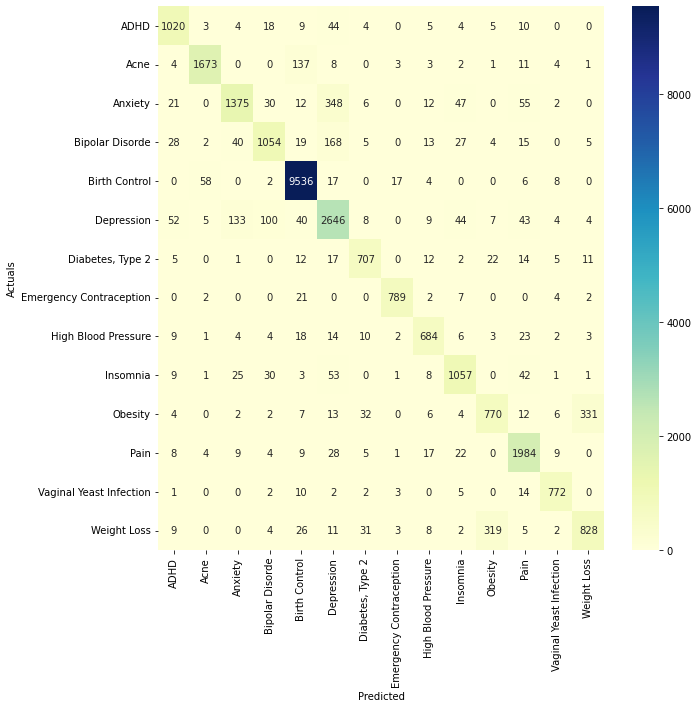

In [22]:
lstm_cm = confusion_matrix(lstm_true, lstm_pred)
plt.subplots(figsize=(10,10))
sns.heatmap(lstm_cm, annot=True, xticklabels=le.classes_, yticklabels=le.classes_, fmt='g', cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actuals")